In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
file_path = '/Users/thomas/Desktop/downstairs_zone/hall_sensor_2024-07-11_00-38-51.csv'
file_path2 = '/Users/thomas/Desktop/downstairs_zone/hall_sensor_2024-07-11_04-31-40.csv'

# Import hall data
df1 = pd.read_csv(file_path)
df1['time'] = df1['time'].apply(lambda x: int(x))
df1 = df1[['time']]
df1['sensor'] = 'Hall'
df3 = pd.read_csv(file_path2)
df3['time'] = df3['time'].apply(lambda x: int(x))
df3 = df3[['time']]
df3['sensor'] = 'Hall'

# Import omega data
df2 = pd.read_csv(file_path.replace('hall','omega'))
df2['time'] = df2['time'].apply(lambda x: int(x))
df2 = df2[['time']]
df2['sensor'] = 'Omega'
df4 = pd.read_csv(file_path2.replace('hall','omega'))
df4['time'] = df4['time'].apply(lambda x: int(x))
df4 = df4[['time']]
df4['sensor'] = 'Omega'

# Add time in minutes relative to first tick
first_tick = min(df1.time[0]/1e9/60, df2.time[0]/1e9/60)
df1['time_min'] = df1['time']/1e9/60 - first_tick
df3['time_min'] = df3['time']/1e9/60 - first_tick
df2['time_min'] = df2['time']/1e9/60 - first_tick
df4['time_min'] = df4['time']/1e9/60 - first_tick

# Remove long break period between 1&2 and 3&4
break_time = list(df3.time_min)[0] - list(df1.time_min)[-1]
df3['time_min'] = df3['time_min'] - break_time
df4['time_min'] = df4['time_min'] - break_time

# Create the hall dataframes
df_hall = pd.concat([df1, df3], ignore_index=True)
df_hall = df_hall.sort_values(by='time')
df_hall = df_hall.reset_index(drop=True)
df_hall['hall_frequency'] = 1 / (df_hall['time'].diff().shift(-1)) * 1e9

# Create the omega dataframe
df_omega = pd.concat([df2, df4], ignore_index=True)
df_omega = df_omega.sort_values(by='time')
df_omega = df_omega.reset_index(drop=True)
df_omega['omega_frequency'] = 1 / (df_omega['time'].diff().shift(-1)) * 1e9

# Merge the hall and omega dataframes
df = pd.concat([df_hall, df_omega], ignore_index=True)
df = df.sort_values(by='time')
df = df.reset_index(drop=True)

# Fill in NaN values
df['hall_frequency'].fillna(method='ffill', inplace=True)
df['omega_frequency'].fillna(method='ffill', inplace=True)

display(df)

/var/folders/c3/d3fq0hlj3j7gpdh35ylfyy1h0000gp/T/ipykernel_6176/1051901691.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['hall_frequency'].fillna(method='ffill', inplace=True)
/var/folders/c3/d3fq0hlj3j7gpdh35ylfyy1h0000gp/T/ipykernel_6176/1051901691.py:54: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['hall_frequency'].fillna(method='ffill', inplace=True)
/var/folders/c3/d3fq0hlj3j7gpdh35ylfyy1h0000gp/T/ipykernel_6176/1051901

,time,sensor,time_min,hall_frequency,omega_frequency
0,1609468153558211000,Omega,0.000000,NaN,0.029901
1,1609468155866447000,Hall,0.038471,33.788350,0.029901
2,1609468155896043000,Hall,0.038964,33.443698,0.029901
3,1609468155925944000,Hall,0.039462,33.700671,0.029901
4,1609468155955617000,Hall,0.039957,33.670034,0.029901
...,...,...,...,...,...
986279,1609492993640664000,Hall,304.998102,33.109294,0.054787
986280,1609492993670867000,Hall,304.998606,33.519928,0.054787
986281,1609492993700700000,Hall,304.999103,33.199429,0.054787
986282,1609492993730821000,Hall,304.999605,32.998944,0.054787


In [15]:
# Filter out errors
df = df[df.omega_frequency<0.1]
df = df[df.omega_frequency>0.01]
df = df[df.hall_frequency>30]

# Crop between the first and last Omega ticks
first_omega_tick = list(df[df.sensor=='Omega'].time)[0]
last_omega_tick = list(df[df.sensor=='Omega'].time)[-1]
df = df[df.time>=first_omega_tick]
df = df[df.time<=last_omega_tick]

# Count the gallons per tick
gallons = len(df[df.sensor=='Omega'])
print(f'Gallons during the section: {round(gallons,1)}')
hall_gallons_per_tick = gallons / len(df[df.sensor=='Hall'])
print(f'Gallons per tick: {round(hall_gallons_per_tick,10)}')
print(f"Average GPM: {round(60*np.mean(df[df.sensor=='Omega'].omega_frequency),2)}")

# Compute the GPM using the gallons per tick
df['hall_GPM'] = df['hall_frequency'] * hall_gallons_per_tick * 60
df['omega_GPM'] = df['omega_frequency'] * 1 * 60

Gallons during the section: 869
Gallons per tick: 0.0008852145
Average GPM: 3.03


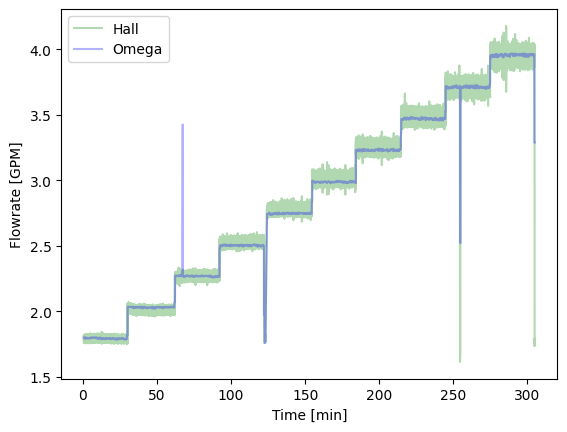

In [16]:
# Plot results
fig, ax = plt.subplots(1,1)
ax.plot(list(df.time_min), list(df.hall_GPM), alpha=0.3, label=f'Hall', color='green')
ax.plot(list(df.time_min), list(df.omega_GPM), alpha=0.3, label=f'Omega', color='blue')
ax.set_ylabel('Flowrate [GPM]')
ax.set_xlabel('Time [min]')
lines1, labels1 = ax.get_legend_handles_labels()
ax.legend()
plt.show()

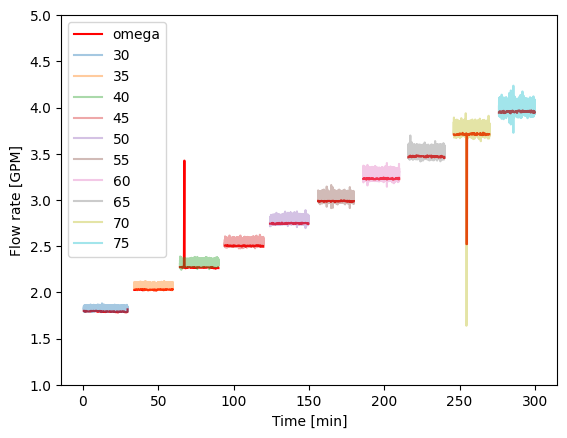

In [17]:
df_backup = df
hall_gpt_list = []
PRINT = False

for section in range(10):
    
    # Get the full data back
    df = df_backup

    # Crop the data to the desired section
    min_time = section*30
    max_time = (section+1)*30
    min_time = min_time+4 if min_time>=30 else min_time
    min_time = min_time+2 if min_time>=150 else min_time
    if PRINT: print('*'*25 + f'\nDistribution pump: {30+section*5}\n' + '*'*25)
    df = df[df.time_min>=min_time]
    df = df[df.time_min<=max_time]

    # Crop between the first and last Omega ticks
    first_omega_tick = list(df[df.sensor=='Omega'].time)[0]
    last_omega_tick = list(df[df.sensor=='Omega'].time)[-1]
    df = df[df.time>=first_omega_tick]
    df = df[df.time<=last_omega_tick]

    # Count the gallons per tick
    gallons = len(df[df.sensor=='Omega'])
    if PRINT: print(f'Gallons during the section: {round(gallons,1)}')
    hall_gallons_per_tick = gallons / len(df[df.sensor=='Hall'])
    hall_gpt_list.append(hall_gallons_per_tick)
    if PRINT: print(f'Gallons per tick: {round(hall_gallons_per_tick,10)}')
    if PRINT: print(f"Average GPM: {round(60*np.mean(df[df.sensor=='Omega'].omega_frequency),2)}")

    # Get average frequency
    if PRINT: print(f"Average hall frequency: {round(np.mean(df[df.sensor=='Hall'].hall_frequency),3)}")
    if PRINT: print(f"Average omega frequency: {round(np.mean(df[df.sensor=='Omega'].omega_frequency),3)}")

    # Compute GPM
    df['hall_GPM'] = df['hall_frequency'] * hall_gallons_per_tick * 60
    df['omega_GPM'] = df['omega_frequency'] * 1 * 60
    
    # Plot results
    if section==0:
        plt.plot(list(df.time_min), list(df.omega_GPM), alpha=1, color='red', label='omega')
    else:
        plt.plot(list(df.time_min), list(df.omega_GPM), alpha=1, color='red')
    plt.plot(list(df.time_min), list(df.hall_GPM), alpha=0.4, label=f'{30+section*5}')
    plt.ylabel('Flow rate [GPM]')
    plt.xlabel('Time [min]')
    plt.ylim([1,5])
    plt.legend()

    #plt.savefig('plot.png', dpi=200)
plt.show()

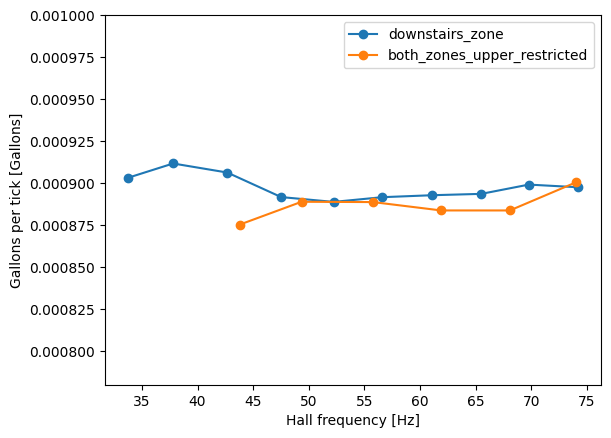

In [18]:
freqs = [33.711, 37.806, 42.673, 47.514, 52.222, 56.611, 61.076, 65.504, 69.776, 74.238]
ticks = [0.0009030961, 0.0009116868, 0.000906298, 0.0008916935, 0.0008888221, 0.0008916298, 0.0008927958, 0.0008936075, 0.0008991244, 0.0008975219]
plt.plot(freqs, ticks, '-o', label='downstairs_zone')

freqs2 = [43.804, 49.357, 55.773, 61.895, 68.068, 74.02]
ticks2 = [0.0008753450879673718, 0.0008889062545788441, 0.0008887157448777103, 0.0008837378739020738, 0.0008837307031530028, 0.0009004750005627969]
plt.plot(freqs2, ticks2, '-o', label='both_zones_upper_restricted')

plt.ylim([0.00078,0.001])
plt.xlabel('Hall frequency [Hz]')
plt.ylabel('Gallons per tick [Gallons]')
plt.legend()
plt.show()